# CP

## Imports

In [1]:
#!pip install pycaret

## Modelo 2 - TESTE

In [14]:
import nltk
from transformers import BertTokenizer, BertModel
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import joblib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# Baixando stopwords apenas se necessário
nltk.download('stopwords', quiet=True)

True

## Analise exploratoria

In [15]:
# Função para carregar dados e realizar análise exploratória
def load_and_explore_data(filepath):
    df = pd.read_csv(filepath, sep=';')
    print(f"Dimensões do dataset: {df.shape}")
    print(f"Colunas do dataset: {df.columns}")
    print(df.describe())

    # Visualização da distribuição de gêneros
    plt.figure(figsize=(10, 6))
    sns.countplot(y=df['genre'], order=df['genre'].value_counts().index)
    plt.title("Distribuição de Gêneros")
    plt.show()

    return df

## Tratamento dos dados

In [16]:
# Função para tratar dados
def clean_data(df):
    df.dropna(inplace=True)  # Remove missing values
    # Removendo stopwords das sinopses
    stop_words = set(stopwords.words('portuguese'))
    df['sinopse_clean'] = df['sinopse'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

    # Encoding para os títulos
    encoder = LabelEncoder()
    df['title_pt_encoded'] = encoder.fit_transform(df['title_pt'])
    return df

### Uso do BERT

In [17]:
# Função para tokenizar e embedar com BERT
def embed_text(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Função para calcular embeddings de todas as sinopses e adicionr no DataFrame
def calculate_embeddings(df, tokenizer, model):
    embeddings = np.vstack([embed_text(text, tokenizer, model) for text in df['sinopse_clean']])
    df['embeddings'] = list(embeddings)  # Salvando os embeddings no DataFrame
    return df

### PCA E Metodo do cotovelo

In [18]:
# Função para ajustar KMeans com PCA e Elbow Method
def cluster_data_with_kmeans(embeddings, n_clusters=None):
    # Redução de dimensionalidade com PCA
    pca = PCA(n_components=100)
    embeddings_pca = pca.fit_transform(embeddings)
    joblib.dump(pca, 'pca_model.joblib')

    # Elbow method para encontrar o número ideal de clusters
    kmeans = KMeans()
    visualizer = KElbowVisualizer(kmeans, k=(2, 30))
    visualizer.fit(embeddings_pca)
    visualizer.show()
    n_clusters = n_clusters or visualizer.elbow_value_
    print(f"Elbow method suggests {n_clusters} clusters.")

    # Ajustando o KMeans com o número de clusters
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=500, n_init=50)
    clusters = kmeans.fit_predict(embeddings_pca)
    joblib.dump(kmeans, 'kmeans_model_2.0.joblib')
    return clusters

In [19]:
# Função para recomendar o filme mais semelhante com base em uma nova sinopse
def recommend_movie(new_synopsis, df, tokenizer, model, pca, kmeans):
    # Gerando embedding para a nova sinopse
    new_embedding = embed_text(new_synopsis, tokenizer, model)
    new_embedding_pca = pca.transform(new_embedding)  # Aplicando PCA na nova sinopse

    # Aplicando PCA nos embeddings dos filmes
    movie_embeddings_pca = np.vstack(df['embeddings'].values)
    movie_embeddings_pca = pca.transform(movie_embeddings_pca)

    # Identificando o cluster mais próximo para a nova sinopse
    cluster = kmeans.predict(new_embedding_pca)

    # Filtrando filmes no mesmo cluster
    same_cluster_movies = df[df['Cluster'] == cluster[0]]

    # Calculando similaridade por cosseno
    cosine_similarities = cosine_similarity(new_embedding_pca, movie_embeddings_pca[same_cluster_movies.index])
    most_similar_idx = np.argmax(cosine_similarities)

    # Retornando o filme mais similar
    recommended_movie = same_cluster_movies.iloc[most_similar_idx]['title_pt']
    return recommended_movie

### Salvando o modelo

In [20]:
# Função para salvar e visualizar clusters
def visualize_and_save_clusters(df, clusters):
    df['Cluster'] = clusters
    df.to_csv('all_movies_with_clusters.csv', sep=';', index=False)

    # Visualização da distribuição de filmes por cluster
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Cluster', data=df)
    plt.title("Distribuição de Filmes por Cluster")
    plt.show()

    # Agrupando os dados por Cluster e Gênero
    cluster_genre_counts = df.groupby(['Cluster', 'genre']).size().reset_index(name='count')

    # Gráfico de distribuição de gêneros em cada cluster
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Cluster', y='count', hue='genre', data=cluster_genre_counts)
    plt.title("Quantidade de Filmes por Gênero em Cada Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Quantidade de Filmes")
    plt.legend(title="Gênero", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

Dimensões do dataset: (250, 6)
Colunas do dataset: Index(['title_pt', 'title_en', 'year', 'rating', 'genre', 'sinopse'], dtype='object')
              year      rating
count   250.000000  250.000000
mean   1986.684000    8.302800
std      25.508171    0.239545
min    1921.000000    7.400000
25%    1966.000000    8.100000
50%    1994.000000    8.200000
75%    2007.000000    8.400000
max    2023.000000    9.300000


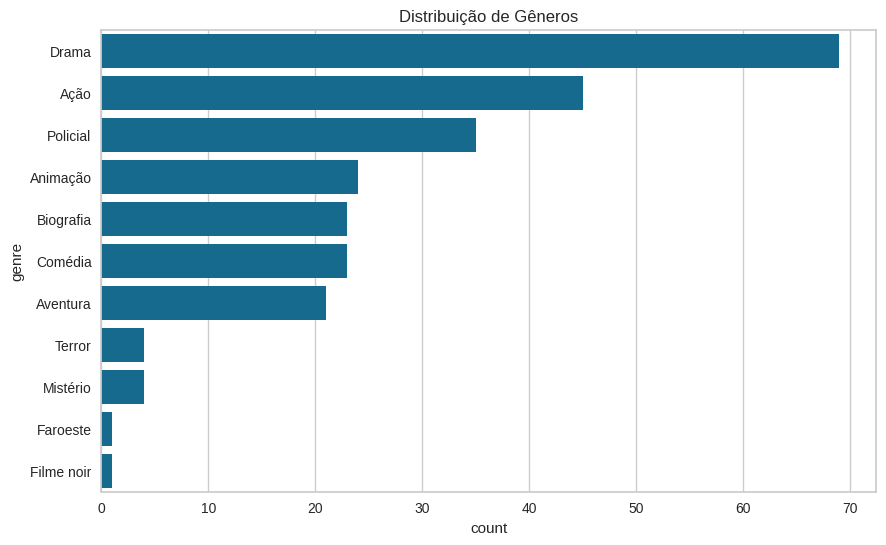

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


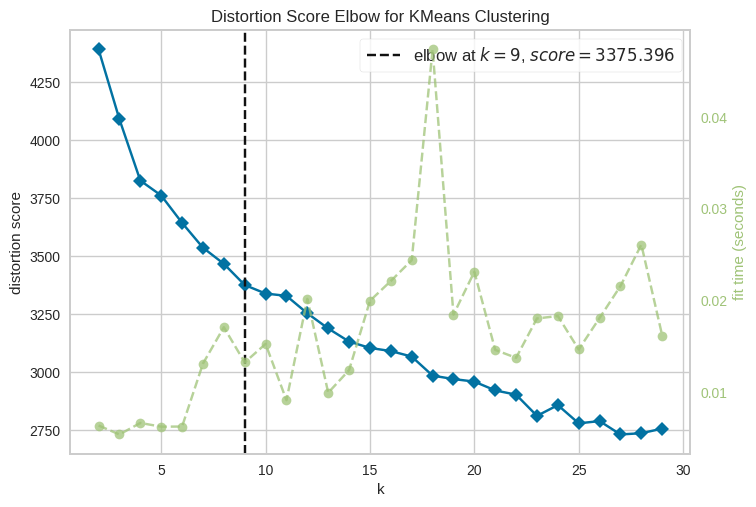

Elbow method suggests 9 clusters.


In [21]:
# Carregar e processar dados
df = load_and_explore_data('all_movies.csv')
df = clean_data(df)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
df = calculate_embeddings(df, tokenizer, model)
embeddings = np.vstack(df['embeddings'].values)
clusters = cluster_data_with_kmeans(embeddings)

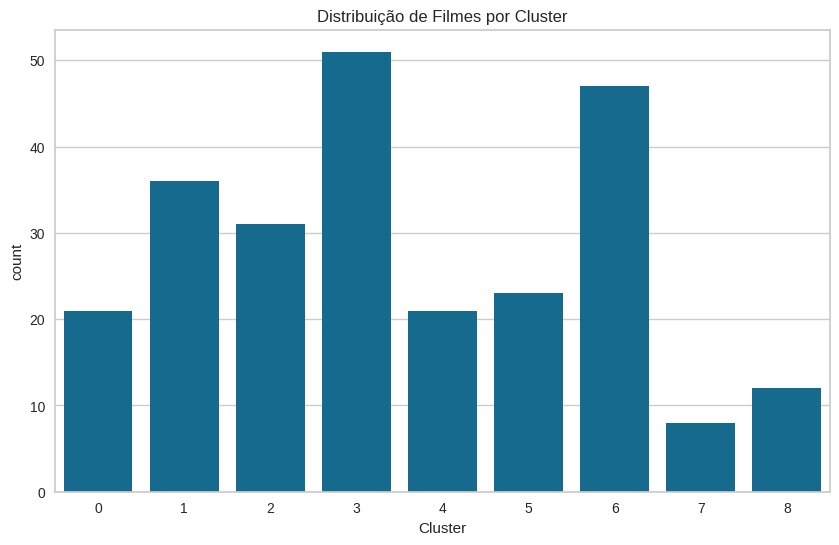

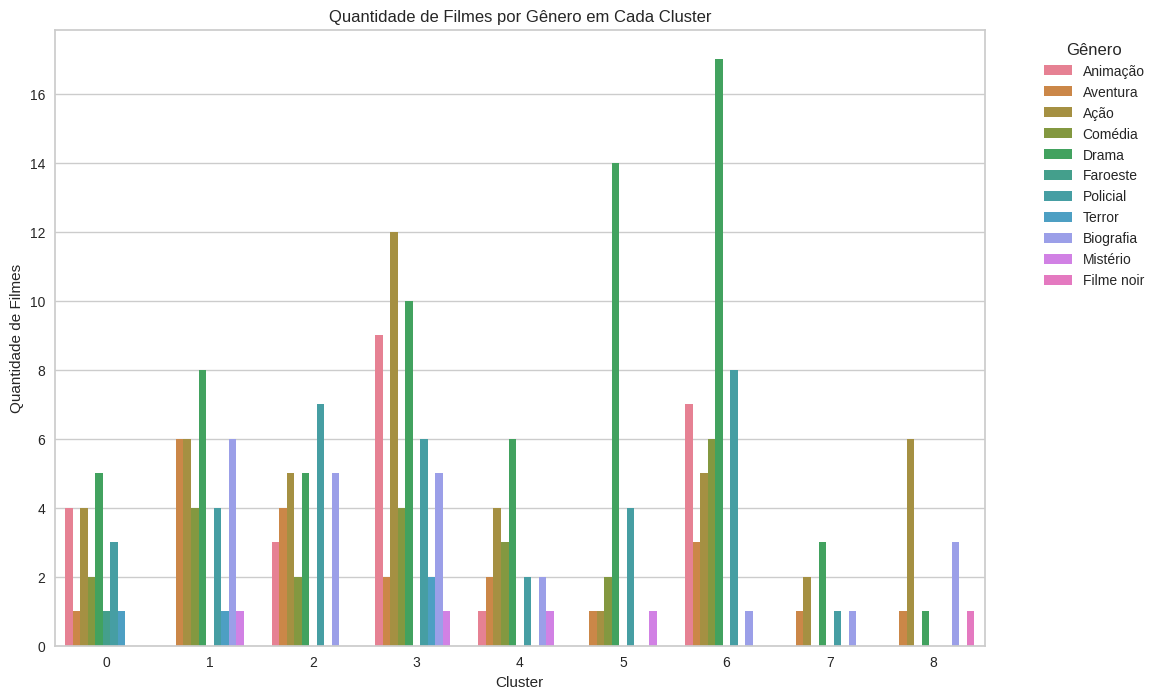

In [22]:
# Visualizando e salvando resultados
visualize_and_save_clusters(df, clusters)

In [23]:
# Exemplo de recomendação de filme
# Carregar modelos já treinados
pca = joblib.load('pca_model.joblib')
kmeans = joblib.load('kmeans_model_2.0.joblib')

### Teste

In [13]:
# Exemplo de nova sinopse
new_synopsis = input("Insira a sinopse: ")

# Recomendar filme mais similar
recommended_movie = recommend_movie(new_synopsis, df, tokenizer, model, pca, kmeans)
print(f"Filme recomendado: {recommended_movie}")

KeyboardInterrupt: Interrupted by user